In [2]:
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/bf/4a/5c86ed8b245aa48f9f819b13a0a9039e9126ba19fdd0c7e0b8026c12315a/tensorflow-1.14.0-cp36-cp36m-win_amd64.whl
  Found existing installation: wrapt 1.10.11


distributed 1.21.8 requires msgpack, which is not installed.
Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!pip install keras

distributed 1.21.8 requires msgpack, which is not installed.
tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [61]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    #print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val,mode="mask", reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mode=="mask":
        print("using mask")
        mask=reuse_split
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    else:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
    
    
    
    
    
    
    
    
    

In [63]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [64]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14,)
    return ax

In [65]:
dfchurn=pd.read_csv(r"C:\Users\kirti\AppData\Local\Temp\Rar$DIa46396.27505\bigml_59c28831336c6604c800002a.csv")
d = {'no': 0, 'yes': 1}
dfchurn['international plan'] = dfchurn['international plan'].map(d).fillna(dfchurn['international plan'])
dfchurn['voice mail plan'] = dfchurn['voice mail plan'].map(d).fillna(dfchurn['voice mail plan'])
dfchurn.head(100)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,391-8027,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,355-9993,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,329-9001,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,117,408,335-4719,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,141,415,330-8173,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


In [67]:
dfchurn["international plan"] = dfchurn["international plan"]== 1
dfchurn["voice mail plan"] = dfchurn["voice mail plan"]== 1

In [68]:
colswewant_cont=[ u'account length', u'number vmail messages', u'total day minutes', u'total day calls', u'total day charge', u'total eve minutes', u'total eve calls', u'total eve charge', u'total night minutes', u'total night calls', u'total night charge', u'total intl minutes', u'total intl calls', u'total intl charge', u'customer service calls']
colswewant_cat=[u"international plan", u'voice mail plan']

In [69]:
ychurn = np.where(dfchurn['churn']==True,1,0) #Highly asym,metric data
100*ychurn.mean()

14.491449144914492

In [70]:
admin_cost=3
offer_cost=100
clv=1000#customer lifetime value

In [71]:
conv=0.5  #Assuming some random costs
tnc = 0.
fpc = admin_cost+offer_cost
fnc = clv
tpc = conv*offer_cost + (1. - conv)*(clv) + admin_cost

In [72]:
cost=np.array([[tnc,fpc],[fnc, tpc]]) #Computing each types of costs
cost

array([[   0.,  103.],
       [1000.,  553.]])

In [73]:
def average_cost(y, ypred, cost): #Defining a function average _cost for the confusion matrix
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

In [74]:
churntrain, churntest = train_test_split(range(dfchurn.shape[0]), train_size=0.6)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

C:\Users\kirti\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


array([False,  True,  True, ...,  True, False,  True])

In [75]:
testchurners=dfchurn['churn'][~churnmask].values==True

In [76]:
testsize = dfchurn[~churnmask].shape[0]  #No customer churns and we send nothing
ypred_dste = np.zeros(testsize, dtype="int")
confusion_matrix(testchurners, ypred_dste)

array([[1135,    0],
       [ 199,    0]], dtype=int64)

In [77]:
#Not doing anything costs us 150 per customer.

In [78]:
ypred_ste = np.ones(testsize, dtype="int") #All customers churn, we send everyone
confusion_matrix(testchurners, ypred_ste)

array([[   0, 1135],
       [   0,  199]], dtype=int64)

In [79]:
steval=average_cost(testchurners, ypred_ste, cost)
steval

170.1289355322339

In [ ]:
#Make offers to everyone costs us even more, not surprisingly. The first one is the one to beat!

In [80]:
from sklearn.naive_bayes import GaussianNB #So lets try a classifier. Here we try one known as Gaussian Naive Bayes. We'll just use the default parameters, since the actual details are not of importance to us.
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, dfchurn, colswewant_cont+colswewant_cat, 'churn', True, 
                                                 mode="mask", reuse_split=churnmask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.88
Accuracy on test data:     0.86
[[1039   96]
 [  97  102]]
########################################################


In [81]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1039,   96],
       [  97,  102]], dtype=int64)

In [82]:
average_cost(ytest, clfgnb.predict(Xtest), cost)

122.40929535232384

In [83]:
#Ok! We did better! Seems much better! But is this the true value of our cost? To answer this question, we need to ask a question: what exactly is clf.predict doing?

#How is it using probabilities? And what if I have classifiers that dont return probabilities?

#For both these reasons we turn to ROC curves.

In [84]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [85]:
average_cost(ytest, repredict(clfgnb, 0.3, Xtest), cost)

118.07496251874063

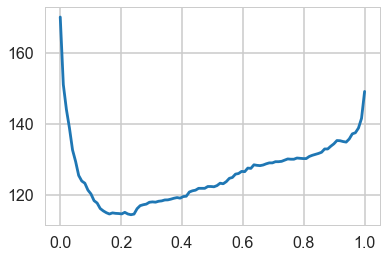

In [86]:
ts = np.linspace(0,1,100)
plt.plot(ts, [average_cost(ytest, repredict(clfgnb, t, Xtest), cost) for t in ts])

(array([886., 147.,  47.,  30.,  26.,  26.,  16.,  11.,  22., 123.]),
 array([1.96065316e-05, 1.00016762e-01, 2.00013917e-01, 3.00011072e-01,
        4.00008227e-01, 5.00005382e-01, 6.00002537e-01, 6.99999692e-01,
        7.99996847e-01, 8.99994002e-01, 9.99991157e-01]),
 <a list of 10 Patch objects>)

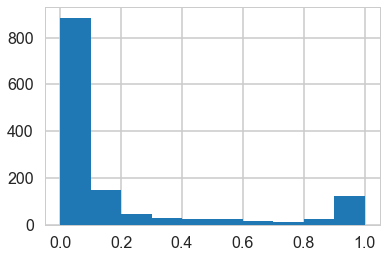

In [87]:
plt.hist(clfgnb.predict_proba(Xtest)[:,1])

In [88]:
from sklearn.metrics import roc_curve, auc

In [89]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

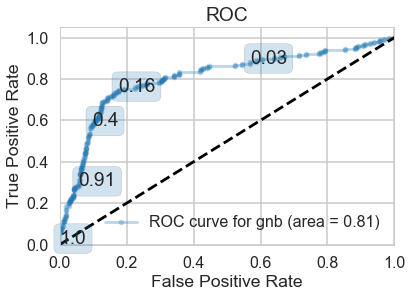

In [90]:
with sns.plotting_context('poster'):
    make_roc("gnb",clfgnb, ytest, Xtest, None, labe=50)

In [91]:
# let us try another classifier.
#Descision trees are very simple things we are all familiar with. If a problem is multi-dimensional, the tree goes dimension by dimension and makes cuts in the space to create a classifier.

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [94]:
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt, {"max_depth": list(range(1,10,1))}, dfchurn, colswewant_cont+colswewant_cat, 'churn', True, 
                                                   mode="not mask", reuse_split=reuse_split)

using reuse split
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.93
[[1111   24]
 [  64  135]]
########################################################


In [95]:
confusion_matrix(ytest,clfdt.predict(Xtest))

array([[1111,   24],
       [  64,  135]], dtype=int64)

In [ ]:
#Letus compare both the classifiers

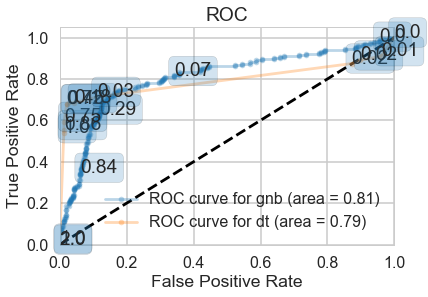

In [96]:
with sns.plotting_context('poster'):
    ax=make_roc("gnb",clfgnb, ytest, Xtest, None, labe=60)
    make_roc("dt",clfdt, ytest, Xtest, ax, labe=1)

In [ ]:
#After some decision theory math

In [97]:
cost

array([[   0.,  103.],
       [1000.,  553.]])

In [98]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [100]:
rat(cost)

0.23042505592841164

In [101]:
def c_repredict(est, c, xtest):
    r = rat(c)
    t=r/(1.+r)
    print("r=", r, "t=", t)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [102]:
average_cost(ytest, c_repredict(clfdt, cost, Xtest), cost)

r= 0.23042505592841164 t= 0.18727272727272729


105.94677661169415

In [103]:
print(rat(cost))
slope = rat(cost)*(np.mean(ytest==0)/np.mean(ytest==1))
slope

0.23042505592841164


1.3142333591896844

In [104]:
z1=np.arange(0.,1., 0.02)
def plot_line(intercepts, slope):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("gnb",clfgnb, ytest, Xtest, ax, labe=60)
    make_roc("dt",clfdt, ytest, Xtest, ax, labe=1)
    z1 = np.linspace(0., 1., 100)
    for intercept in intercepts:
        ax.plot(z1 , slope*z1 + intercept, 'k-')

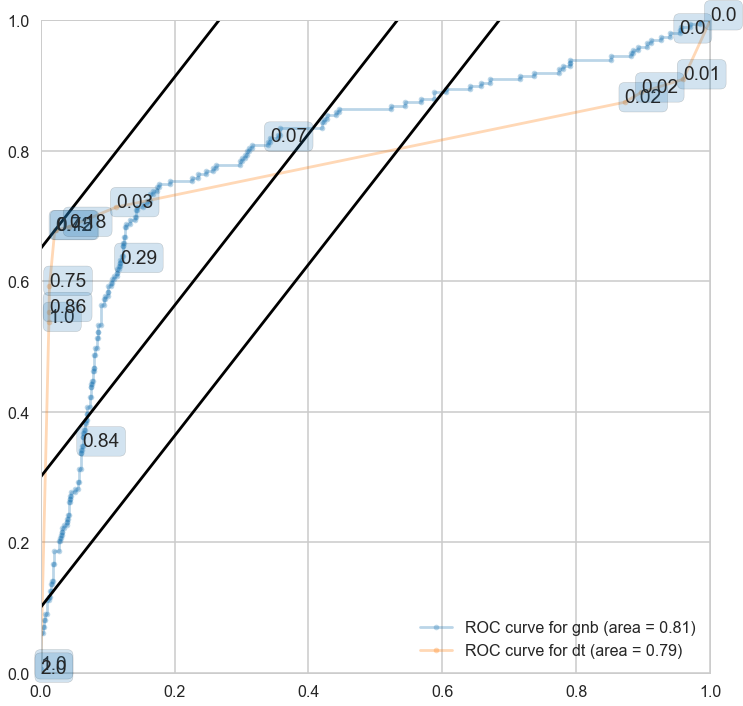

In [105]:
plot_line([0.1,0.3, 0.65], slope)

In [ ]:
#plot the cost/profit (per person) per threshold on a ROC like curve to see which classifier maximizes profit/minimizes cost?

In [106]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

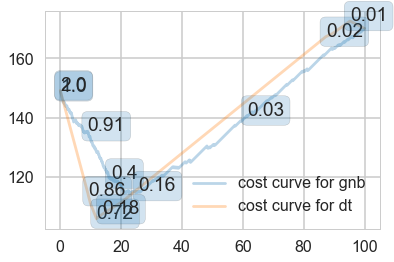

In [107]:
with sns.plotting_context('poster'):
    ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, threshold=True, labe=50);
    plot_cost("dt",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=2);


In [108]:
cost

array([[   0.,  103.],
       [1000.,  553.]])

In [109]:
#The above graph is a snapshot of a run. One thing worth noticing is that classifiers perform differently in different regions. If you targeted only the top 20% of your users..and these are the ones most likely to churn so you should target them first, you would want to use the decision-tree classifier. And you might only get to target these top 20 given your budget. Remember that there is a cost associated with targeting predicted positives. That cost can be read of the graph above. Say we had a million customers. Now, at 10%, or 100,000 we are talking about a minimum budget of 10.3 million dollars.
#If 10-15 million is your budget, then you use the decision tree classifier on your left. If 40-60 million is your budget, roughly, you would use the gnb classifier instead.